# Nonlinear Langevin with Double-Welled Potential

Here we take for out potential the function $$V(x) = 1/4(x^2-1)^2$$ and so the (overdamped, stochastic) Langenvin equation is $$dX_t = -V'(X_t)dt + \sigma dW_t = -X_t(X_t^2-1) + \sigma dW_t$$
We solve this numerically in various ways to get an approximate solution if to the equation. For instance we will often use Euler-Maruyama which soluction takes the form 
$$Y_{n+1} = Y_{n} + \Delta t\big(-Y_n(Y_n^2-1)\big) + \sigma \sqrt{\Delta t}v_n$$
where $Y_n \approx X_{\Delta t n}$ and $v_n \sim N(0,1)$ for all $n = 0,1,2,\dots$ are i.i.d.

The goal here is to reproduce the statisical and dynamical information (?). Of a realization of $Y = (Y_n;\;n=o,1,2,\dots)$ using a reduced model. We will compare the autocavariances as well as the pdf the $Y_n$. 

So, first we run the full model. To do this I use the function `DataGen_DWOL` found in th file `DataGen.jl` found in the current folder (`Examples\Nonlinear Langevin`).

In [14]:
using PyPlot

include("DataGen.jl") # This has many packages in it's preamble
include("../../Tools/Model_Reduction_Dev.jl")

vector_wiener_filter_fft

In [15]:
steps = 10^5 + 1
scheme = "FE"
t_start = 0
t_stop = 10^3
discard = 100000
sig_init = [1.5]
sigma = [1]
V_prime = x -> -x.*(x.^2 .- 1)
SM1 = false
Obs_noise = false
d = 1
e = randn(d,steps + discard)


Y = DataGen_DWOL(
    steps;
    scheme, t_start, t_stop, discard, 
    sig_init , sigma, V_prime,
    SM1, Obs_noise, d, e
    )

1×100001 Array{Float64,2}:
 -0.396202  -0.389564  -0.214373  …  1.39396  1.47098  1.49552  1.45434

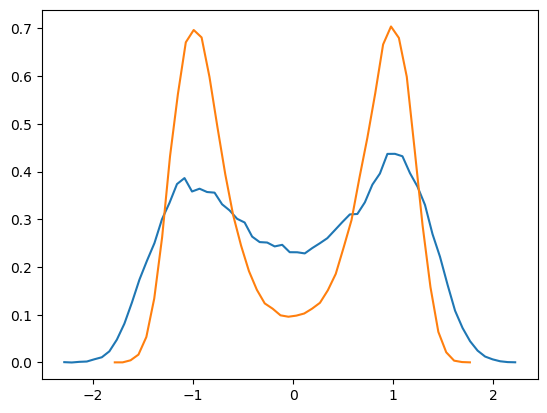

In [16]:
emp_pdf(Y[:],plt = true);

Noi = DWOL_dist_samp(100000,σ = sigma)
emp_pdf(Noi,plt = true);
